# Juan Carlos Perez Ramirez
## Procesamiento de Lenguaje Natural
## Tarea 4: Modelo de Lenguaje de Política

# Preprocesamiento y tratamiento de datos
Se limpiaron los saltos de linea y espacios multiples, asi como los "|". Se empleo el tokenizador de oraciones de nltk, que separa las oraciones de acuerdo a la aparicion de puntos (sin contar los de abreviaturas), signos de interrogacion y exclamacion, etc.

In [1]:
import glob
def files_to_string(directory, pattern):
    '''
    Lee todos los archivos de un directorio que satisfacen el patron dado,
    los almacena en una lista de strings y los devuelve.
    '''
    contents = {}

    for file in glob.glob(directory + pattern):
        with open(file, 'r', encoding="utf-8") as f:
            contents[file[-14:-4]] = f.read()
    
    return contents

In [2]:
file_path = "../../Corpus/estenograficas_limpias_por_fecha/"
data = files_to_string(file_path, "*")

In [3]:
from unidecode import unidecode
corpus = ""
corpus = corpus.join(data.values()).lower()
#corpus = unidecode(corpus)

In [4]:
import re
import string

corpus = re.sub(r"\d+", "", corpus)
corpus = re.sub(r"\s+", " ", corpus).strip()
corpus = corpus.replace("|", "")


In [5]:
corpus[:100]

'versión estenográfica. conferencia de prensa de la presidenta claudia sheinbaum pardo del de octubre'

In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /home/juancho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
oraciones = sent_tokenize(corpus, language='spanish')

In [7]:
oraciones[:5]

['versión estenográfica.',
 'conferencia de prensa de la presidenta claudia sheinbaum pardo del de octubre de  presidencia de la república  gobierno  gob.mx interruptor de navegación trámites gobierno english interruptor de navegación versiones estenográficas prensa protección de datos personales transparencia inicio presidencia de la república blog aa+ aa- publicaciones recientes nuevo -- :: - versión estenográfica.',
 'entrega de tarjetas del programa de mejoramiento de vivienda para el bienestar nuevo -- :: - versión estenográfica.',
 'entrega de tarjetas vivienda para el bienestar nuevo -- :: - versión estenográfica.',
 'entrega de tarjetas vivienda para el bienestar nuevo -- :: - versión estenográfica.']

In [8]:
from nltk.probability import FreqDist

class NgramData:

    def __init__(self, vocab_max, tokenizer):
        self.vocab_max = vocab_max
        self.tokenizer = tokenizer
        self.UNK = "<unk>"
        self.SOS = "<s>"
        self.EOS = "</s>"
        self.final_vocabulary = set()

    def fit(self, raw_texts):
        freq_dist = FreqDist()
        tokenized_corpus = []

        for txt in raw_texts:
            tokens = self.tokenizer.tokenize(txt)
            tokenized_corpus.append(tokens)
            for w in tokens:
                freq_dist[w] += 1

        self.final_vocabulary = set(tok for tok, _ in freq_dist.most_common(self.vocab_max))
        self.final_vocabulary.update([self.UNK, self.SOS, self.EOS])

        transformed_corpus = [self.transform(tokens) for tokens in tokenized_corpus]

        return transformed_corpus
    
    def mask_oov(self, word):
        return self.UNK if word not in self.final_vocabulary else word
    
    def add_sos_eos(self, tokens):
        return [self.SOS, self.SOS, self.SOS] + tokens + [self.EOS]

    def transform(self, tokens):
        transformed = [self.mask_oov(w) for w in tokens]
        transformed = self.add_sos_eos(transformed)
        return transformed


# Modelo de Lenguaje y Evaluación
## Tetragram

In [9]:
import math
class TetragramLanguageModel:

    def __init__(self, lambda_tetra=0.4, lambda_tri=0.3, lambda_bi=0.2, lambda_uni=0.1):
        
        self.lambda_tetra = lambda_tetra
        self.lambda_tri = lambda_tri
        self.lambda_bi = lambda_bi
        self.lambda_uni = lambda_uni

        # Contadores
        self.unigram_counts = {}
        self.bigram_counts = {}
        self.trigram_counts = {}
        self.tetragram_counts = {}

        self.vocab = 0
        self.total_tokens = 0
        self.V = 0

    def set_lambdas(self, lambda_tetra, lambda_tri, lambda_bi, lambda_uni):

        self.lambda_tetra = lambda_tetra
        self.lambda_tri = lambda_tri
        self.lambda_bi = lambda_bi
        self.lambda_uni = lambda_uni

    def train(self, transformed_corpus, final_vocabulary):
        self.vocab = set(final_vocabulary)
        self.V = len(final_vocabulary)

        for tokens in transformed_corpus:
            for i, w in enumerate(tokens):

                # Unigramas
                self.unigram_counts[w] = self.unigram_counts.get(w, 0) + 1

                # Bigramas
                if i > 0:
                    w_prev = tokens[i-1]
                    self.bigram_counts[(w_prev, w)] = self.bigram_counts.get((w_prev, w), 0) + 1

                # Trigramas
                if i > 1:
                    w_prev2 = tokens[i-2]
                    self.trigram_counts[(w_prev2, w_prev, w)] = self.trigram_counts.get((w_prev2, w_prev, w), 0) + 1

                # Tetragramas
                if i > 2:
                    w_prev3 = tokens[i-3]
                    self.tetragram_counts[(w_prev3, w_prev2, w_prev, w)] = self.tetragram_counts.get((w_prev3, w_prev2, w_prev, w), 0) + 1
                    
        self.total_tokens = sum(self.unigram_counts.values())

    def mask_oov(self, word):
        return "<unk>" if word not in self.vocab else word

    def unigram_probability(self, w):
        return (self.unigram_counts.get(self.mask_oov(w), 0) + 1) / (self.total_tokens + self.V)

    def bigram_probability(self, w_prev, w):
        w_prev = self.mask_oov(w_prev)
        w = self.mask_oov(w)
        numerator = self.bigram_counts.get((w_prev, w), 0) + 1
        denominator = self.unigram_counts.get(w_prev, 0) + self.V
        return numerator / denominator

    def trigram_probability(self, w_prev2, w_prev, w):
        w_prev2 = self.mask_oov(w_prev2)
        w_prev = self.mask_oov(w_prev)
        w = self.mask_oov(w)
        numerator = self.trigram_counts.get((w_prev2, w_prev, w), 0) + 1
        denominator = self.bigram_counts.get((w_prev2, w_prev), 0) + self.V
        return numerator / denominator

    def tetragram_probability(self, w_prev3, w_prev2, w_prev, w):
        w_prev3 = self.mask_oov(w_prev3)
        w_prev2 = self.mask_oov(w_prev2)
        w_prev = self.mask_oov(w_prev)
        w = self.mask_oov(w)
        numerator = self.tetragram_counts.get((w_prev3, w_prev2, w_prev, w), 0) + 1
        denominator = self.trigram_counts.get((w_prev3, w_prev2, w_prev), 0) + self.V
        return numerator / denominator

    def probability_of_word(self, w_prev3, w_prev2, w_prev, w):
        return self.lambda_tetra * self.tetragram_probability(w_prev3, w_prev2, w_prev, w) + \
                self.lambda_tri * self.trigram_probability(w_prev2, w_prev, w) + \
                self.lambda_bi * self.bigram_probability(w_prev, w) + \
                self.lambda_uni * self.unigram_probability(w)

    def sequence_probability(self, sequence):
        log_prob = 0.0
        l = len(sequence)
        for i in range(3, l):
            context = sequence[i-3:i]
            w = sequence[i]
            p = self.probability_of_word(context[-3], context[-2], context[-1], w)
            log_prob += math.log(p + 1e-10)  # Para evitar log(0)

        return log_prob  # Devuelve la log-probabilidad sin hacer exp()



    def check_prob(self):
        print(sum(self.unigram_probability(w) for w in self.vocab))
        print(sum(self.bigram_probability("hola", w) for w in self.vocab))
        print(sum(self.trigram_probability("hola", "como", w) for w in self.vocab))
        print(sum(self.tetragram_probability("hola", "como", "te", w) for w in self.vocab))


In [10]:
import numpy as np

indices = np.arange(len(oraciones))
np.random.shuffle(indices)

train_size = int(len(indices) * 0.8)
val_size = int(len(indices) * 0.1)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_corpus = [oraciones[i] for i in train_indices]
val_corpus = [oraciones[i] for i in val_indices]
test_corpus = [oraciones[i] for i in test_indices]

## Entrenamiento
Se separo el corpus total en una parte de entrenamiento (80% de los datos), una de validacion y una de prueba (10% cada una), entrenando a los cuatro modelos de lenguaje con el primer set, usando un vocabulario de 40 mil tokens (mas los tokens especiales de inicio y fin de linea y token desconocido).

Los tokens no vistos se enmascaran con el simbolo "\<unk\>" para evitar probabilidades nulas.

In [11]:
from nltk.tokenize import sent_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r"[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ]+")

ngram_data = NgramData(40000, tokenizer)
transformed_corpus = ngram_data.fit(train_corpus)
final_vocab = ngram_data.final_vocabulary

In [12]:
tetra_lm = TetragramLanguageModel(lambda_tetra=1, lambda_tri=0, lambda_bi=0, lambda_uni=0)
tri_lm = TetragramLanguageModel(lambda_tetra=0, lambda_tri=1, lambda_bi=0, lambda_uni=0)
bi_lm = TetragramLanguageModel(lambda_tetra=0, lambda_tri=0, lambda_bi=1, lambda_uni=0)
uni_lm = TetragramLanguageModel(lambda_tetra=0, lambda_tri=0, lambda_bi=0, lambda_uni=1)

In [13]:
tetra_lm.train(transformed_corpus, final_vocab)
print("Tetra listo")
tri_lm.train(transformed_corpus, final_vocab)
print("Tri listo")
bi_lm.train(transformed_corpus, final_vocab)
print("Bi listo")
uni_lm.train(transformed_corpus, final_vocab)
print("Uni listo")

Tetra listo
Tri listo
Bi listo
Uni listo


A continuacion se muestran dos ejemplos: uno con una secuencia de palabras presentes en el vocabulario y otra con un token no visto.

In [17]:
w_prev3, w_prev2, w_prev, w = "políticos", "de", "la", "oposición"
words = [w_prev3, w_prev2, w_prev, w]

is_there = True
for word in words:
    is_there = is_there and word in final_vocab
    if not is_there:
        print(f"La palabra '{word}' no esta en el corpus.")
        break
if is_there:
    print("Todas las palabras estan en el corpus.")

p_w = tetra_lm.tetragram_probability(*words)
print(f"\nP('{w}' | '{w_prev3}', '{w_prev2}', '{w_prev}') = {p_w:.16f}")

p_w = tri_lm.trigram_probability(*words[1:])
print(f"\nP('{w}' | '{w_prev2}', '{w_prev}') = {p_w:.16f}")

p_w = bi_lm.bigram_probability(*words[2:])
print(f"\nP('{w}' | '{w_prev}') = {p_w:.16f}")

p_w = uni_lm.unigram_probability(w)
print(f"\nP('{w}') = {p_w:.16f}")

Todas las palabras estan en el corpus.

P('oposición' | 'políticos', 'de', 'la') = 0.0001249625112466

P('oposición' | 'de', 'la') = 0.0018416206261510

P('oposición' | 'la') = 0.0017329854728229

P('oposición') = 0.0000820228100446


In [22]:
w = "picafresa"
if not w in final_vocab:
    print(f"La palabra '{w}' no esta en el corpus.")

p_w = tetra_lm.tetragram_probability(*words)
print(f"\nP('{w}' | '{w_prev3}', '{w_prev2}', '{w_prev}') = {p_w:.16f}")

p_w = tri_lm.trigram_probability(*words[1:])
print(f"\nP('{w}' | '{w_prev2}', '{w_prev}') = {p_w:.16f}")

p_w = bi_lm.bigram_probability(*words[2:])
print(f"\nP('{w}' | '{w_prev}') = {p_w:.16f}")

p_w = uni_lm.unigram_probability(w)
print(f"\nP('{w}') = {p_w:.16f}")

La palabra 'picafresa' no esta en el corpus.

P('picafresa' | 'políticos', 'de', 'la') = 0.0001249625112466

P('picafresa' | 'de', 'la') = 0.0018416206261510

P('picafresa' | 'la') = 0.0017329854728229

P('picafresa') = 0.0044435652126803


La estrategia empleada para palabras no nulas parece funcionar, si bien, debido a que las palabras que no quedaron en el vocabulario final se agrupan bajo el token desconocido, la probabilidad de aparicion de palabras no vistas es bastante alta, llevando a casos como este en el que la palabra "picafresa" tiene una probabilidad de aparicion mas alta que "oposición".

## Modelo interpolado (lambdas sugeridas)

Con las particiones detalladas arriba, se calculo la perplejidad para los modelos con los conjuntos de lambdas sugeridas, modificando sus valores en el modelo de tetragramas entrenado previamente.

In [16]:
import math

def perplexity(model, corpus):
    l = len(corpus)
    log_prob = 0.0
    for i in range(3, l):
        w_prev3 = corpus[i-3]
        w_prev2 = corpus[i-2]
        w_prev = corpus[i-1]
        w = corpus[i]
        p = model.probability_of_word(w_prev3, w_prev2, w_prev, w)
        log_prob += math.log(p + 1e-10)
    return math.exp(-log_prob / l)

In [29]:
val_txt = ''.join(val_corpus)
test_txt = ''.join(test_corpus)
transformed_val = ngram_data.fit([val_txt])
transformed_test = ngram_data.fit([test_txt])

El mejor valor de la perplejidad alcanzada es bastante alto, atribuible al reducido tamano del corpus asi como a la presencia de basura en los documentos empleados para el entrenamiento.

In [30]:
# Definir tres conjuntos de lambdas
lambda_sets = [
    (0.4, 0.3, 0.2, 0.1),
    (0.1, 0.2, 0.3, 0.4),
    (0.1, 0.4, 0.4, 0.1)
]

best_lambda = None
best_perplexity = float('inf')

for lambdas in lambda_sets:
    tetra_lm.set_lambdas(*lambdas)
    
    # Calcular perplejidad en validación
    val_perplexity = perplexity(tetra_lm, transformed_val[0])
    print(f"Perplejidad en validación: {val_perplexity}\n")
    
    # Guardar el mejor modelo
    if val_perplexity < best_perplexity:
        best_perplexity = val_perplexity
        best_lambda = lambdas

print(f"Mejores lambdas seleccionadas: {best_lambda}")


Perplejidad en validación: 828.1654233712904

Perplejidad en validación: 480.6488924929459

Perplejidad en validación: 598.923852110968

Mejores lambdas seleccionadas: (0.1, 0.2, 0.3, 0.4)


La perplejidad medida en el corpus de prueba es bastante similar al observado en el conjunto de validacion, indicando un buen desempeno del modelo al tratar con secuencias no vistas.

In [31]:
tetra_lm.set_lambdas(*best_lambda)
test_perplexity = perplexity(tetra_lm, transformed_test[0])
print(f"Perplejidad en test: {test_perplexity}")

Perplejidad en test: 483.3050425132002


Mi companera Kathia Rangel Pompa me ayudo con la siguiente funcion, puesto que mi intento por implementarla tardaba demasiado tiempo. 

In [63]:
import numpy as np

def expectation_maximization(model, val_sequence, max_iter=10):
    N = 4
    lambdas = np.array([0.25, 0.25, 0.25, 0.25])
    perplexities = []

    for i in range(max_iter):
        # Entrenar modelo con lambdas actuales
        model.set_lambdas(*lambdas)
        
        q_m = np.zeros((len(val_sequence)-3, N))

        # E-step
        for m in range(3, len(val_sequence)):
            w_prev3, w_prev2, w_prev, w = val_sequence[m-3], val_sequence[m-2], val_sequence[m-1], val_sequence[m]

            p_4 = model.tetragram_probability(w_prev3, w_prev2, w_prev, w)
            p_3 = model.trigram_probability(w_prev2, w_prev, w)
            p_2 = model.bigram_probability(w_prev, w)
            p_1 = model.unigram_probability(w)

            probs = np.array([p_4, p_3, p_2, p_1])

            q = probs * lambdas
            q /= q.sum() # Normalizamos
            q_m[m-3] = q

        # M-step
        lambdas = q_m.mean(axis=0)

        # Calcular perplejidad
        ppl = perplexity(model, val_sequence)
        perplexities.append(ppl)

        if i % 2 == 0:
            print(f"Iteration: {i}, Perplejidad: {ppl}")

    return lambdas, perplexities

Al emplear EM se alcanzo una perplejidad muy similar a la mejor de las observadas en los conjuntos de lambdas anteriores, y dado que la convergencia mejora muy poco entre las ultimas iteraciones parece indicar que posiblemente sea el mejor resultado alcanzable por el modelo en estas circunstancias.

In [64]:
lambdas, perplexities = expectation_maximization(tetra_lm, transformed_val[0])
print(lambdas)

Iteration: 0, Perplejidad: 589.2285644387551
Iteration: 2, Perplejidad: 402.8371860169364
Iteration: 4, Perplejidad: 389.1047611298884
Iteration: 6, Perplejidad: 386.4106180111605
Iteration: 8, Perplejidad: 385.6031428432458
[2.41138675e-06 1.59294668e-03 6.39186374e-01 3.59218268e-01]


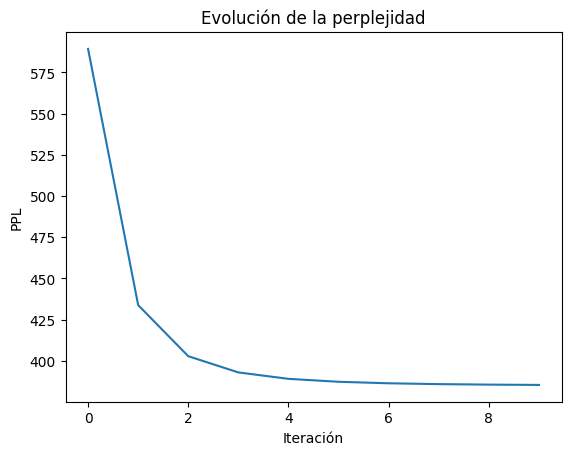

In [65]:
import matplotlib.pyplot as plt

plt.plot(perplexities)
plt.xlabel("Iteración")
plt.ylabel("PPL")
plt.title("Evolución de la perplejidad")
plt.show()

## Generación de Texto
Se propone que, al calcular la probabilidad del tetragrama que incluye como token final "\</s\>", se multiplique su probabilidad por un factor alpha. Con cada iteracion, el valor de alpha se vuelve un poco mas grande (se multiplica por si mismo) para que, conforme avanza el algoritmo se vuelva mas probable elegir ese token

In [15]:
V = list(final_vocab)
tetra_lm.set_lambdas(*lambdas)

## Generar texto
Para la generacion de texto, se elige una palabra inicial al azar (asegurandose de que no es un final de linea). Hecho esto, se van agregando palabras a la oracion generada, calculando las probabilidades de los n-gramas segun su tamano, y tomando las secuencias mas probables tomando todas las palabras del vocabulario.

Fue necesario agregar una condicion para no agregar los tokens de inicio de linea ni de palabra desconocida dentro de la oracion. El hecho de que la aparicion de inicios de linea **despues** de otro token podria deberse a que, dado que el modelo empleado toma en cuenta unigramas, la probabilidad de aparicion de este token sea mayor a la de otras palabras en el contexto dado.

In [67]:
import random

def generate_text(V, model, max_words=50, n=15, alpha=1.00001):
    sentence = []

    # Asegurar que la primera palabra no sea "</s>"
    while not sentence or sentence[0] == "</s>":
        sentence = [random.choice(V)]

    for _ in range(max_words - 1):
        candidates = []
        for word in V:
            if word in ["<s>", "<unk>"]:  # No se debe generar <s> ni <unk> dentro de la oración
                continue

            if len(sentence) == 1:
                prob = model.bigram_probability(sentence[-1], word)
            elif len(sentence) == 2:
                prob = model.trigram_probability(sentence[-2], sentence[-1], word)
            else:
                prob = model.probability_of_word(sentence[-3], sentence[-2], sentence[-1], word)

            # Aumentar la probabilidad de `</s>` a medida que la oración crece
            if word == "</s>":
                prob *= alpha
                alpha *= alpha

            candidates.append((prob, word))

        # Ordenar por probabilidad descendente y tomar los mejores n candidatos
        candidates.sort(reverse=True, key=lambda x: x[0])
        words = [word for _, word in candidates[:n]]
        probs = [prob for prob, _ in candidates[:n]]

        # Elegir palabra de manera ponderada por probabilidad
        word = random.choices(words, weights=probs, k=1)[0]
        sentence.append(word)

        if word == "</s>":
            break

    return " ".join(sentence)

Al observar las secuencias generadas es evidente la aparicion de secuencias repetidas, debido a que se trata de palabras que suelen ser muy utilizadas en el mismo contexto y en secuencias diferentes (por ejemplo, "y el de la que se"), volviendo su repeticion en la secuencia bastante probable.

In [69]:
for _ in range(5):
    print(generate_text(V, tetra_lm, n=25))

ponerme acudió atención porque si hay un en un la gente porque las elecciones de la corrupción </s>
exconvento atención importaran el los pueblos es que se que la conferencia de méxico y de que de la </s>
compañeritos prosperó importaran a el caso de méxico </s>
detuvo a juan y </s>
azvi prosperó calumniaban por ciento el caso de la defensa </s>


## Generar texto con semilla
La modificacion hecha respecto a la funcion anterior consistio en eliminar la eleccion de una palabra inicial y los casos para oraciones de menos de 3 palabras, quedando solo la generacion a partir de tetragramas.

In [71]:
import random

def generate_text_from_seed(seed, V, model, max_words=50, n=15, alpha=1.00001):
    sentence = seed

    for _ in range(max_words - 1):
        candidates = []
        for word in V:
            if word in ["<s>", "<unk>"]:  # No se debe generar <s> ni <unk> dentro de la oración
                continue

            prob = model.probability_of_word(sentence[-3], sentence[-2], sentence[-1], word)

            # Aumentar la probabilidad de `</s>` a medida que la oración crece
            if word == "</s>":
                prob *= alpha
                alpha *= alpha

            candidates.append((prob, word))

        # Ordenar por probabilidad descendente y tomar los mejores n candidatos
        candidates.sort(reverse=True, key=lambda x: x[0])
        words = [word for _, word in candidates[:n]]
        probs = [prob for prob, _ in candidates[:n]]

        # Elegir palabra de manera ponderada por probabilidad
        word = random.choices(words, weights=probs, k=1)[0]
        sentence.append(word)

        if word == "</s>":
            break

    return " ".join(sentence)

Se observan secuencias mas largas ligeramente mas coherentes que las observables en el caso anterior, dado que el contexto ingresado reduce bastante las secuencias que pueden generarse limitandolas a oraciones mas reconocibles.

In [74]:
print(generate_text_from_seed(["<s>", "<s>", "<s>"], V, tetra_lm))
print(generate_text_from_seed(["andrés", "manuel", "lópez"], V, tetra_lm))

<s> <s> <s> y no en de las </s>
andrés manuel lópez obrador bueno el gobierno federal </s>


## Permutacion de tokens
Una vez generadas todas las permutaciones, se calculan las probabilidades de todas, se ordenan y se devuelven las 5 mayores y las 5 menores, observando correctamente como las primeras tienen mas sentido que las segundas.

In [17]:
from itertools import permutations

def top_permutations(model, sentence, k = 5):
    tokens = sentence.split()
    p = list(permutations(tokens))
    probs = []

    for sequence in p:
        p = math.exp(model.sequence_probability(sequence))
        probs.append((' '.join(sequence), p))

    probs = sorted(probs, key=lambda x: x[1])
    top = probs[-k:]
    bottom = probs[:k]

    return top, bottom

In [18]:
oraciones = ["sino gano me voy a la chingada", "ya se va a acabar la corrupción", "el presidente de la republica"]
for o in oraciones:
    top, bottom = top_permutations(tetra_lm, o)
    print(f"Oración: {o}")
    print("\nTop:")
    for seq, prob in top:
        print(f"{seq} - {prob}")
    print("\nBottom:")
    for seq, prob in bottom:
        print(f"{seq} - {prob}")
    print("\n")

Oración: sino gano me voy a la chingada

Top:
chingada sino gano me voy a la - 5.982246272716484e-08
sino gano chingada me voy a la - 5.982452086903397e-08
gano sino chingada me voy a la - 5.982452086903397e-08
gano chingada sino me voy a la - 6.987079996692766e-08
chingada gano sino me voy a la - 6.987079996692766e-08

Bottom:
me la a chingada sino voy gano - 1.082067184003965e-18
la me a chingada sino voy gano - 1.082079333266404e-18
me la a chingada voy gano sino - 1.0922775094238117e-18
la me a chingada voy gano sino - 1.0922897733260035e-18
me la a chingada voy sino gano - 1.1388677682246309e-18


Oración: ya se va a acabar la corrupción

Top:
acabar ya se va a la corrupción - 3.2410238553290115e-06
ya acabar corrupción se va a la - 3.5814492916629095e-06
acabar ya corrupción se va a la - 3.5814492916629095e-06
corrupción acabar ya se va a la - 2.3057249021089386e-05
acabar corrupción ya se va a la - 2.3057284412373972e-05

Bottom:
se a la acabar va ya corrupción - 6.9273602982020

## 5 palabras mas probables dadas las 3 primeras
Ayude a mi companero Isaac Barron Jimenez con la siguiente funcion

Se observa que las palabras devueltas por el algoritmo tienen, efectivamente, sentido dentro del contexto ingresado.

In [22]:
def top5_next_word(model, word1, word2, word3):
    probs = [(w, model.probability_of_word(word1, word2, word3, w)) for w in model.vocab]
    probs = sorted(probs, key=lambda x: x[1], reverse=True)
    return probs[:5]

In [23]:
print(top5_next_word(tetra_lm, "andrés", "manuel", "lópez"))

[('obrador', 0.3370457999973343), ('<s>', 0.03978256940808791), ('de', 0.017766097468775645), ('</s>', 0.013621542215995961), ('que', 0.011950694070485714)]


# El Ahorcado
Se implifico el codigo para que, en lugar de generar todas las posibles palabras que se forman por permutacion, insercion y eliminacion de letras, genere solo aquellas que se producen al reemplazar un "\_" por una letra.

Entre las pruebas se incluyen strings de 3 y 4 "\_", con lo que el algoritmo devuelve las palabras mas comunes de 3 y 4 letras, respectivamente.

In [95]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../../Corpus/big.txt').read()))

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def hangman(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(generate_possible_words(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

from itertools import product
import string

def generate_possible_words(pattern):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    blanks = pattern.count('_')  # Contar la cantidad de '_'
    
    # Generar todas las combinaciones posibles de letras para los espacios vacíos
    replacements = product(letters, repeat=blanks)
    
    words = []
    for replacement in replacements:
        temp_pattern = list(pattern)  # Convertir el string en una lista mutable
        rep_index = 0  # Índice para recorrer replacement
        
        # Reemplazar cada '_' por una letra del alfabeto
        for i, char in enumerate(temp_pattern):
            if char == '_':
                temp_pattern[i] = replacement[rep_index]
                rep_index += 1
        
        words.append("".join(temp_pattern))  # Convertir lista a string y agregar a la lista de palabras
    
    return words

In [103]:
patterns = ["pe_p_e", "phi__sop_y", "si_nif_c_nc_", "c_mp_t_r", "a_tifi__a_", "_m__nit_", "a__le_e", "f_r_e", "___", "____"]
for pattern in patterns:
    print(f'{pattern} -> {hangman(pattern)}')

pe_p_e -> people
phi__sop_y -> philosophy
si_nif_c_nc_ -> significance
c_mp_t_r -> computer
a_tifi__a_ -> artificial
_m__nit_ -> immunity
a__le_e -> athlete
f_r_e -> force
___ -> the
____ -> that


Una manera de integrar el modelo de Norvig al modelo de lenguaje seria que, al analizar secuencias que posean una probabilidad de ocurrencia anormalmente baja ("anormal" respecto a algun umbral), encuentre la palabra que esta fuera de lugar al calcular su probabilidad de ocurrencia dentro del contexto y corregirla con el modelo de Norvig. Esto encontraria y corregiria errores como el caso de "In the science off Maths ..." asi como otros mas complejos, por ejemplo el caso de que mas de una palabra este escrita incorrectamente.